In [10]:
!pip install git+https://github.com/MinRegret/tigercontrol.git

  Cloning https://github.com/MinRegret/tigercontrol.git to /private/var/folders/7f/s33r9hxx1wg05ggrbzwk4zzc0000gn/T/pip-req-build-smelmas2
  Running command git clone -q https://github.com/MinRegret/tigercontrol.git /private/var/folders/7f/s33r9hxx1wg05ggrbzwk4zzc0000gn/T/pip-req-build-smelmas2
  Created wheel for tigercontrol: filename=tigercontrol-0.1-cp36-none-any.whl size=155312 sha256=50aeb5dadd63e0c0a3f14cf3a7dbb401e3d3e7dee3ec4c4a21b3604d7f815421
  Stored in directory: /private/var/folders/7f/s33r9hxx1wg05ggrbzwk4zzc0000gn/T/pip-ephem-wheel-cache-6y2yejhd/wheels/68/8c/d4/4545a6bf5fe7fde74989bdda96791b48a263e7ddc5d401a4e2
Successfully built tigercontrol
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
import matplotlib.pyplot as plt
import jax.numpy as np
import tigercontrol
from tigercontrol.controllers import Controller
from jax import grad,jit
import jax
from tigercontrol.utils.random import set_key

ModuleNotFoundError: No module named 'tigercontrol'

In [19]:
def get_trajectory(environment, controller, key = 0, T = 100):
    set_key(key)

    (environment_id, environment_params) = environment
    (controller_id, controller_params) = controller
    
    environment = tigercontrol.environment(environment_id)
    x = environment.reset(**environment_params)
    
    controller_params['A'], controller_params['B'] = environment.A, environment.B
    controller_params['x'] = x
    
    controller = tigercontrol.controllers(controller_id)
    controller.initialize(**controller_params)
    
    trajectory = []
    norms = []
    avg_regret = []
    cur_avg = 0
    
    if(controller.is_online):
        for i in range(T):
            u = controller.plan(x)
            x = environment.step(u)
            trajectory.append(x) # get trajectory
            norms.append(np.linalg.norm(x))
            cur_avg = (i / (i + 1)) * cur_avg + (np.linalg.norm(x) + np.linalg.norm(u)) / (i + 1)
            avg_regret.append(cur_avg)
    else:
        u = controller.plan()
        for i in range(T):
            x = environment.step(u[i])
            trajectory.append(x)
            norms.append(np.linalg.norm(x))
            cur_avg = (i / (i + 1)) * cur_avg + (np.linalg.norm(x) + np.linalg.norm(u[i])) / (i + 1)
            avg_regret.append(cur_avg)
            
    return trajectory, norms, avg_regret

In [20]:
T = 500

In [21]:
n = 1 # dimension of  the state x 
m = 1 # control dimension
noise_magnitude = 0.2
noise_distribution = 'normal'

environment_id = "LDS-v0"
environment_params = {'n': n, 'm' : m, 'noise_magnitude' : noise_magnitude, 'noise_distribution' : noise_distribution}

In [22]:
H, HH = 3, 30
GPC_params = {'n' : n, 'm' : m, 'H' : H, 'HH' : HH, 'K' : np.zeros((m, n))}

In [23]:
GPC_results, GPC_norms, GPC_avg_results = get_trajectory((environment_id, environment_params), ('GPC', GPC_params), key = 0, T = T)

/Users/paulag/anaconda3/lib/python3.6/site-packages/jax/numpy/linalg.py:58: UserWarning: numpy.linalg support is experimental and may cause silent failures or wrong outputs
  warnings.warn(_EXPERIMENTAL_WARNING)


In [24]:
C = np.identity(n + m) # quadratic cost
LQR_params = {'C' : C, 'T' : T}

In [25]:
LQR_results, LQR_norms, LQR_avg_results = get_trajectory((environment_id, environment_params), ('LQR', LQR_params), key = 0, T = T)

/Users/paulag/anaconda3/lib/python3.6/site-packages/jax/numpy/linalg.py:58: UserWarning: numpy.linalg support is experimental and may cause silent failures or wrong outputs
  warnings.warn(_EXPERIMENTAL_WARNING)
/Users/paulag/anaconda3/lib/python3.6/site-packages/jax/numpy/linalg.py:119: UserWarning: numpy.linalg support is experimental and may cause silent failures or wrong outputs
  warnings.warn(_EXPERIMENTAL_WARNING)
/Users/paulag/anaconda3/lib/python3.6/site-packages/jax/numpy/linalg.py:211: UserWarning: numpy.linalg support is experimental and may cause silent failures or wrong outputs
  warnings.warn(_EXPERIMENTAL_WARNING)


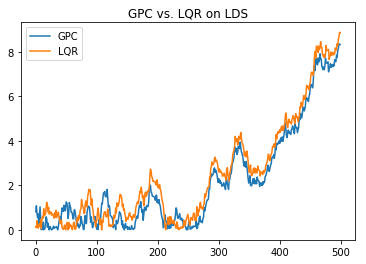

In [26]:
plt.plot(GPC_norms, label = "GPC")
plt.plot(LQR_norms, label = "LQR")
plt.title("GPC vs. LQR on LDS");
plt.legend();

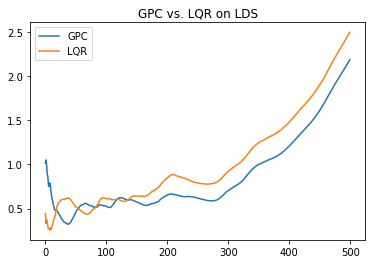

In [27]:
plt.plot(GPC_avg_results, label = "GPC")
plt.plot(LQR_avg_results, label = "LQR")
plt.title("GPC vs. LQR on LDS");
plt.legend();